<a href="https://colab.research.google.com/github/pranay8297/deep-learning-projects/blob/master/image_restoration_own.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install "torch==1.4" "torchvision==0.5.0" #use the old version

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 49.0MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [2]:
!pip freeze | grep torch

torch==1.4.0
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.5.0


In [3]:
!pip install ipdb
from ipdb import set_trace as st

  Created wheel for ipdb: filename=ipdb-0.13.4-cp36-none-any.whl size=10973 sha256=c08abacb17a028fe6e8245a51a8b598c50ebd91136d57e4801e84c4e022c28ad
  Stored in directory: /root/.cache/pip/wheels/56/51/e4/c91c61e3481a1a967beb18c4ea7a2b138a63cce94170b2e206
Successfully built ipdb


In [4]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import hooks

from PIL import Image, ImageDraw
import random

In [5]:
path = untar_data(URLs.PETS)
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [6]:
##### PART - 1 --- Data
path_mr = path/'medium'
path_lr = path/'lower'
path_hr = path/'images'
path_final = path/'higher'

path_mr.mkdir(exist_ok = True, parents = True)
path_lr.mkdir(exist_ok = True, parents = True)
path_final.mkdir(exist_ok = True, parents = True)

im_path = path_hr.ls()[1]
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/medium'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/higher'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/lower')]

In [7]:
#test
def test_parallel(*args, **kwargs):
  print(args, kwargs)

# parallel(partial(crappify, path = "Indiana", solly = "solly"), ["a", "b", "c"])
img = Image.open(im_path).convert('RGB')
img.size

(355, 500)

In [8]:
from random import randint
items = ImageList.from_folder(path/'images').items

def crappify(im_path, _, **kwargs):
  size, dest, quality = kwargs['size'], kwargs['destination'], kwargs['quality']
  dest.mkdir(exist_ok = True, parents = True)
  image = Image.open(im_path).convert('RGB')
  targ_size = resize_to(image, size, use_min = True)
  image = image.resize(targ_size)
  w, h = image.size
  # quality = randint(30, 60)
  # cords, fill, text = (randint(0, w), randint(0, h)), tuple([randint(0, 255) for i in range(3)]), str(randint(100, 999))
  # ImageDraw.Draw(image).text(cords, text, fill = fill)
  image.save(dest/im_path.name, quality = quality)

In [9]:
ps_map = [(path_lr, 128, 30), (path_mr, 256, 50), (path_final, 352, 70)]
for pat, sz, q in ps_map:
  parallel(partial(crappify, destination = pat, size = sz, quality = q), items)

In [8]:
#test
path_mr.ls()[:3], path_lr.ls()[:3], path_final.ls()[:3]

([PosixPath('/root/.fastai/data/oxford-iiit-pet/medium/leonberger_116.jpg'),
  PosixPath('/root/.fastai/data/oxford-iiit-pet/medium/Persian_126.jpg'),
  PosixPath('/root/.fastai/data/oxford-iiit-pet/medium/Persian_196.jpg')],
 [PosixPath('/root/.fastai/data/oxford-iiit-pet/lower/leonberger_116.jpg'),
  PosixPath('/root/.fastai/data/oxford-iiit-pet/lower/Persian_126.jpg'),
  PosixPath('/root/.fastai/data/oxford-iiit-pet/lower/Persian_196.jpg')],
 [PosixPath('/root/.fastai/data/oxford-iiit-pet/higher/leonberger_116.jpg'),
  PosixPath('/root/.fastai/data/oxford-iiit-pet/higher/Persian_126.jpg'),
  PosixPath('/root/.fastai/data/oxford-iiit-pet/higher/Persian_196.jpg')])

In [10]:
bs = 8
size = 352

In [11]:
def get_data(path, size, bs):
  src = ImageImageList.from_folder(path).split_by_rand_pct().label_from_func(lambda x: path_hr/x.name)
  data = src.transform(get_transforms(max_rotate=4.0), tfm_y = True, size = size).databunch(bs = bs).normalize(imagenet_stats, do_y= True)
  return data

In [12]:
def get_src(path):
  return ImageImageList.from_folder(path).split_by_rand_pct().label_from_func(lambda x: path_hr/x.name)

def get_data_from_src(src, size = 128, bs = 8):
  return src.transform(get_transforms(max_rotate=4.0), tfm_y = True, size = size).databunch(bs = bs).normalize(imagenet_stats, do_y= True)

In [13]:
s_high = get_src(path_final)
s_med = get_src(path_mr)
s_low = get_src(path_lr)

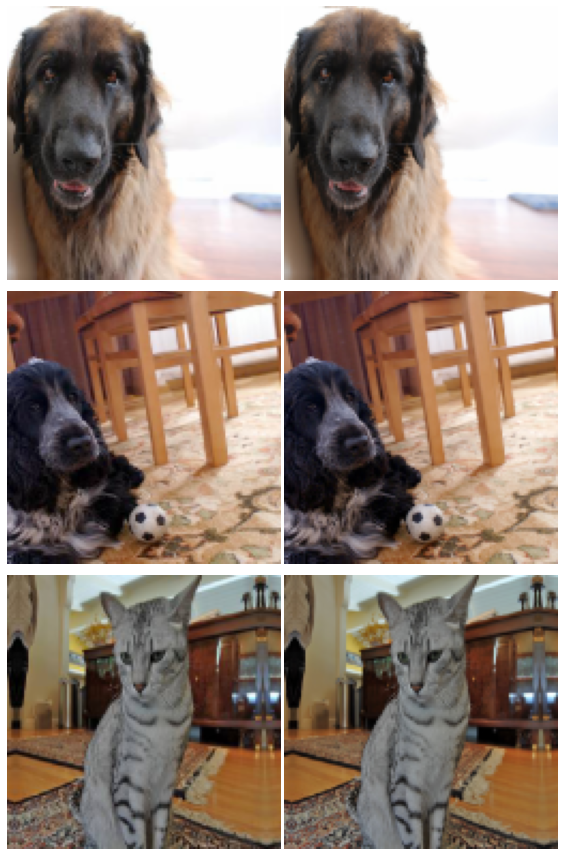

In [14]:
# data = get_data(path_lr, size, bs)
d_high_small = get_data_from_src(s_high, size = 128)
d_high_small.show_batch(rows = 3)

In [15]:
# PART 2 ------ Loss Function
from torchvision.models import vgg16_bn
vgg = vgg16_bn()

In [19]:
#test
vgg
hasattr(vgg, 'features')
c = 0
for i in vgg.features:
  print(type(i))
  c += 1
  if c > 7:
    break
# vgg
type(vgg.features)

<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.pooling.MaxPool2d'>
<class 'torch.nn.modules.conv.Conv2d'>


torch.nn.modules.container.Sequential

In [16]:
base_model = vgg.features.cuda().eval()
base_model.requires_grad = False

In [17]:
#Basically all MaxPool2d layers are downsapmling parts... so hook all the previous layers to maxpool2d
down_layers = [i-1 for i, l in enumerate(base_model) if isinstance(l, torch.nn.modules.pooling.MaxPool2d)]
down_layers

[5, 12, 22, 32, 42]

In [22]:
#test
type(children(base_model))

list

In [18]:
base_loss = F.l1_loss
base_loss

<function torch.nn.functional.l1_loss>

In [19]:
#set layer weights... this is to specify what is the importance for each down layer activations
layer_wgts = [2., 12., 14., 7., 4.]

In [20]:
#define a class called Hook

class Hook():
  
  def __init__(self, layer):

    self.layer = layer
    self.stored = None
    self.hook = self.layer.register_forward_hook(self.hook_fn)
    self.removed = False
  
  def hook_fn(self, layer, input, output):

    self.stored = output
  
  def remove(self):

    self.stored = None
    if not self.removed:
      self.hook.remove()
      self.removed = True


In [21]:
class FeatureLoss(nn.Module):

  def __init__(self, base_model, down_layers, layer_wgts):

    super().__init__()
    self.base = base_model
    self.layer_idxs = down_layers
    self.layer_wgts = layer_wgts
    self.layers = [base_model[i] for i in self.layer_idxs]
    self.hooks = [Hook(i) for i in self.layers]
    self.metric_names = ["Pixel_loss"] + [f"act_loss: {i}" for i in self.layer_idxs]
  
  def get_acts(self, inp):
    
    _ = self.base(inp)
    return [i.stored for i in self.hooks]
  
  def forward(self, yhat, yb):

    acts_yb = self.get_acts(yb)
    acts_yhat = self.get_acts(yhat)
    pixel_loss = base_loss(yhat, yb)
    feature_losses = [w*base_loss(i, o) for i, o, w in zip(acts_yhat, acts_yb, self.layer_wgts)]
    losses = [pixel_loss, *feature_losses]
    self.metrics = dict(zip(self.metric_names, losses))
    return sum(losses)


In [24]:
loss_func = FeatureLoss(base_model, down_layers, layer_wgts)

In [25]:
data = d_high_small
for xb, yb in data.train_dl:
  break

loss = loss_func(xb, yb)
print(loss, loss_func.metrics)

tensor(0.3145, device='cuda:0', grad_fn=<AddBackward0>) {'Pixel_loss': tensor(0.0694, device='cuda:0'), 'act_loss: 5': tensor(0.0234, device='cuda:0', grad_fn=<MulBackward0>), 'act_loss: 12': tensor(0.0948, device='cuda:0', grad_fn=<MulBackward0>), 'act_loss: 22': tensor(0.0850, device='cuda:0', grad_fn=<MulBackward0>), 'act_loss: 32': tensor(0.0271, device='cuda:0', grad_fn=<MulBackward0>), 'act_loss: 42': tensor(0.0148, device='cuda:0', grad_fn=<MulBackward0>)}


In [26]:

def get_learner(data = data, arch = models.resnet34):
  return unet_learner(data, arch, loss_func = loss_func, blur = True, norm_type=NormType.Weight)
gc.collect()

13430

In [27]:
learn = get_learner()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


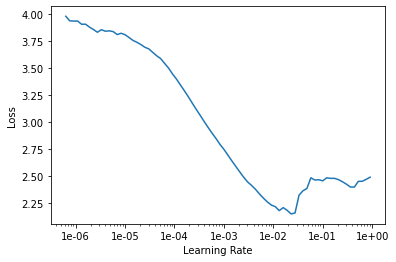

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
def fit_model(name, epocs, lrs):
  learn.fit_one_cycle(epocs, max_lr= lrs)
  learn.save('name')

fit_model('stage_1', 5, slice(1e-03))

epoch,train_loss,valid_loss,time
0,0.293489,0.277163,01:43
1,0.260464,0.254058,01:43
2,0.240146,0.250018,01:43
3,0.226290,0.240476,01:43
4,0.224185,0.238330,01:43


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


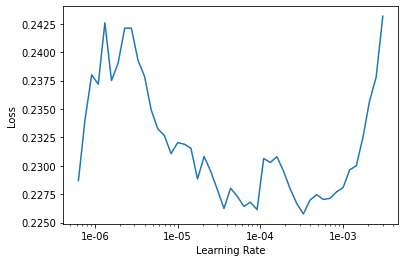

In [30]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(10, max_lr = slice(1e-04), wd = 1e-03)

epoch,train_loss,valid_loss,time
0,0.230918,0.238623,01:45
1,0.230988,0.238915,01:45
2,0.228284,0.238525,01:45
3,0.222188,0.238526,01:45
4,0.229596,0.238962,01:45
5,0.228021,0.237629,01:45
6,0.223364,0.236887,01:45
7,0.225681,0.236739,01:45
8,0.227313,0.236494,01:45
9,0.220945,0.236571,01:45


In [32]:
learn.save('stage_2')
d_high_large = get_data_from_src(s_high, size = 224)

In [33]:
learn = None
data = None
gc.collect()

6094

In [34]:
data = d_high_large
learn = get_learner(data = data)
learn.load('stage_2')
learn.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


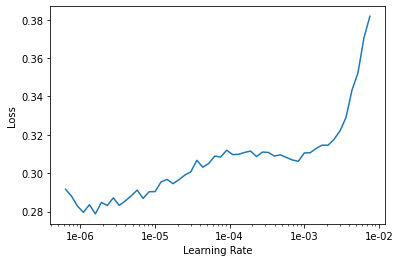

In [35]:
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(5, max_lr = slice(1e-04))

epoch,train_loss,valid_loss,time
0,0.302356,0.313690,02:43
1,0.305987,0.313591,02:42
2,0.292814,0.311450,02:42
3,0.293458,0.310694,02:42
4,0.306977,0.310716,02:42


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


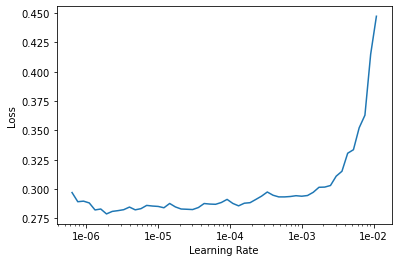

In [37]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [38]:
learn.fit_one_cycle(10, max_lr = slice(1e-6, 3e-04))


epoch,train_loss,valid_loss,time
0,0.298434,0.312031,02:48
1,0.299864,0.316198,02:48
2,0.297258,0.311740,02:48
3,0.292304,0.312948,02:48
4,0.315217,0.311022,02:48
5,0.292872,0.308878,02:48
6,0.303678,0.309612,02:48
7,0.295851,0.310321,02:48
8,0.303094,0.308183,02:48
9,0.296010,0.307908,02:48


In [54]:
learn.save(mpath/'stage_3')

In [42]:
d_med_small = get_data_from_src(s_med, size = 128)
tl = get_learner(data = d_med_small)
tl.load('stage_3')

FileNotFoundError: ignored

In [55]:
mpath = path/'models'
mpath.mkdir(exist_ok = True)

tl.load(mpath/'stage_3')

Learner(data=ImageDataBunch;

Train: LabelList (5912 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /root/.fastai/data/oxford-iiit-pet/medium;

Valid: LabelList (1478 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /root/.fastai/data/oxford-iiit-pet/medium;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilati

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


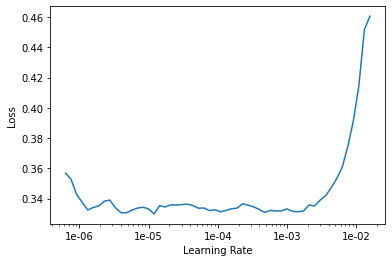

In [56]:
d_med_small = get_data_from_src(s_med, size = 128)
learn = None
data = None
gc.collect()
data = d_med_small
learn = get_learner(data = data)
learn.freeze()
learn.load(mpath/'stage_3')
learn.lr_find()
learn.recorder.plot()

In [38]:
!ls /root/.fastai/data/oxford-iiit-pet/medium/models. 

ls: cannot access '/root/.fastai/data/oxford-iiit-pet/medium/models.': No such file or directory


In [57]:
lrs = 1e-3
learn.fit_one_cycle(5, slice(lrs))

epoch,train_loss,valid_loss,time
0,0.321998,0.343418,01:24
1,0.332231,0.344007,01:25
2,0.320407,0.340963,01:25
3,0.320823,0.337739,01:25
4,0.314511,0.336689,01:24


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


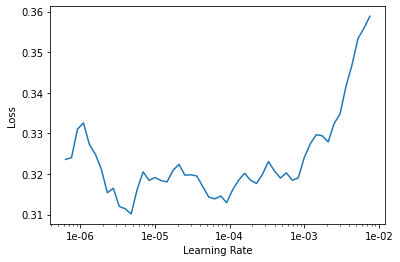

In [58]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [59]:
learn.fit_one_cycle(10, slice(1e-04))
learn.save(mpath/'stage_4')

epoch,train_loss,valid_loss,time
0,0.317119,0.336364,01:30
1,0.320049,0.336592,01:30
2,0.321771,0.336337,01:29
3,0.318928,0.336099,01:30
4,0.315623,0.336720,01:30
5,0.312485,0.337599,01:30
6,0.307310,0.336790,01:30
7,0.321599,0.335511,01:30
8,0.314690,0.335489,01:30
9,0.311274,0.335782,01:30


In [ ]:
learn.save(mpath/'stage_4')
tl.load(mpath/'stage_4')

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


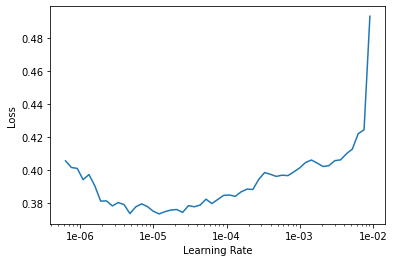

In [62]:
learn = None
data = None
gc.collect()
d_med_large = get_data_from_src(s_med, size = 224)
data = d_med_large
learn = get_learner(data = data)
learn.freeze()
learn.load('stage_4')
learn.lr_find()
learn.recorder.plot()

In [64]:
lrs = 3e-04
learn.fit_one_cycle(3, slice(lrs))

epoch,train_loss,valid_loss,time
0,0.377268,0.377159,02:40
1,0.372859,0.378351,02:40
2,0.371330,0.375792,02:40


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


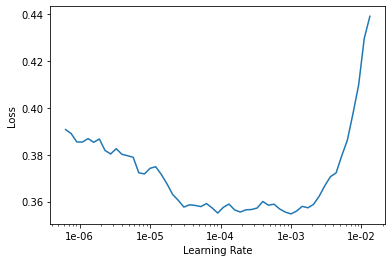

In [65]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [66]:
learn.fit_one_cycle(8, slice(3e-04))
learn.save(mpath/'stage_5')

epoch,train_loss,valid_loss,time
0,0.377052,0.377674,02:47
1,0.380962,0.378946,02:47
2,0.369336,0.381432,02:47
3,0.372814,0.378343,02:47
4,0.370622,0.378295,02:47
5,0.372353,0.374521,02:47
6,0.377730,0.374294,02:47
7,0.379913,0.373390,02:47


In [ ]:
tl.load(mpath/'stage_5')

In [70]:
learn = None
data = None
gc.collect()

95

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


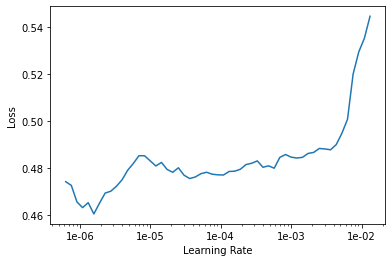

In [72]:
d_low_small = get_data_from_src(s_low, size = 128)
data = d_low_small
learn = get_learner(data = data)
learn.load(mpath/'stage_5')
learn.lr_find()
learn.recorder.plot()

In [73]:
learn.fit_one_cycle(5, slice(1e-04))

epoch,train_loss,valid_loss,time
0,0.476059,0.503402,01:20
1,0.481694,0.503312,01:19
2,0.474375,0.505467,01:20
3,0.472080,0.503693,01:20
4,0.471522,0.501473,01:20


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


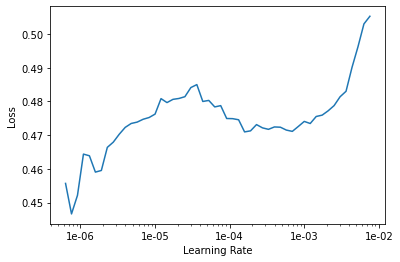

In [74]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [75]:
learn.fit_one_cycle(8, slice(3e-04))


epoch,train_loss,valid_loss,time
0,0.472287,0.502430,01:27
1,0.464818,0.498857,01:27
2,0.467007,0.500306,01:27
3,0.478324,0.497666,01:27
4,0.471635,0.495991,01:27
5,0.475485,0.497739,01:27
6,0.464996,0.494496,01:27
7,0.468360,0.495403,01:27


In [76]:
learn.save(mpath/'stage_6')

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


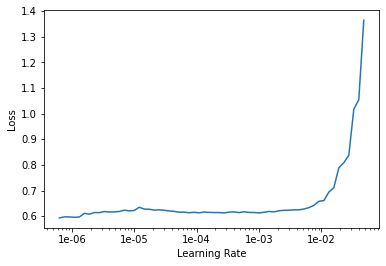

In [77]:
d_low_large = get_data_from_src(s_low, size = 224)
data = None
learn = None
gc.collect()
learn = get_learner(data = d_low_large)
learn.load(mpath/'stage_6')
learn.lr_find()
learn.recorder.plot()

In [78]:
learn.fit_one_cycle(4, slice(3e-04))

epoch,train_loss,valid_loss,time
0,0.582475,0.585813,02:39
1,0.588583,0.583823,02:39
2,0.576087,0.581540,02:39
3,0.580793,0.580456,02:39


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


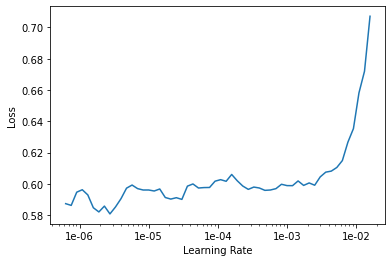

In [79]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [80]:
learn.fit_one_cycle(8, slice(1e-04))

epoch,train_loss,valid_loss,time
0,0.575590,0.580221,02:46
1,0.589578,0.581797,02:47
2,0.588014,0.579249,02:46
3,0.572060,0.577394,02:46
4,0.565478,0.577587,02:46
5,0.563761,0.576419,02:47
6,0.567333,0.575725,02:46
7,0.580731,0.576364,02:46


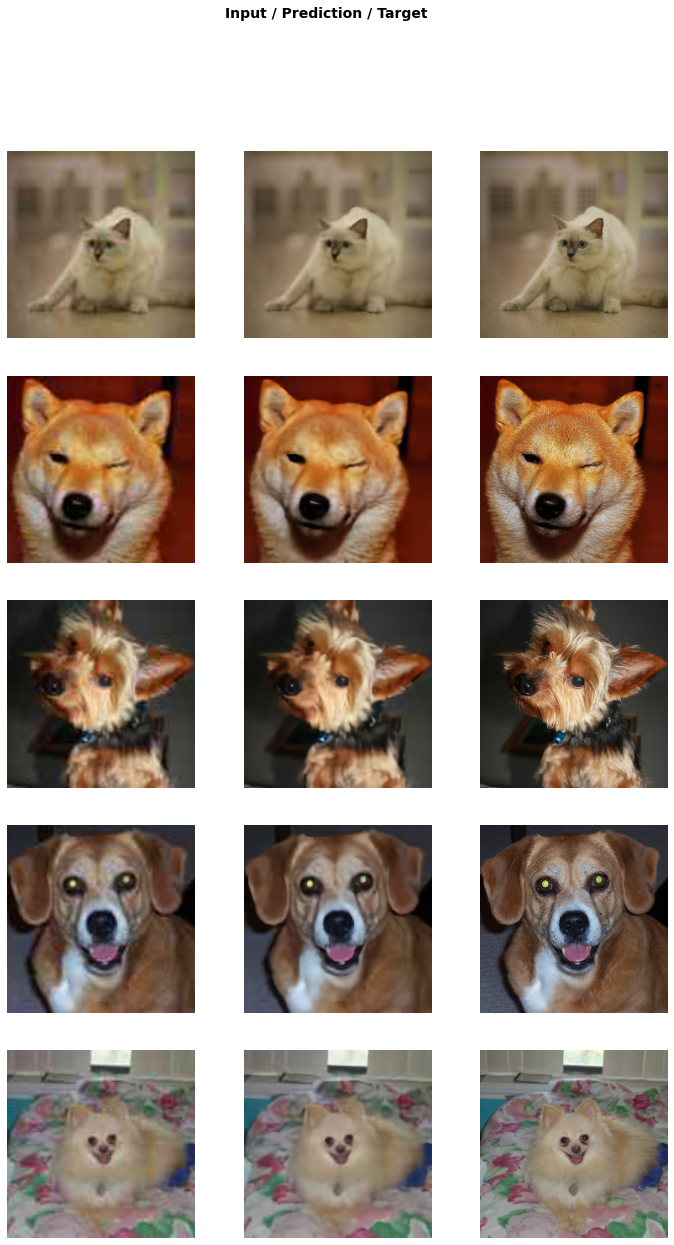

In [81]:
learn.show_results()